In [1]:
import os
os.chdir('/home/drl/PycharmProjects/DeployedProjects/pararl')

from otter.gym.bullet.kinova import Kinova
import visdom

import pybullet as p
import numpy as np
import time
import pybullet_data
 

In [2]:


KINOVA_HOME_ANGLE = [4.543, 3.370, -0.264, 0.580, 2.705, 4.350, 6.425, 0, 0,0 ]

timeStep = 0.01
p.connect(p.GUI)
p.resetSimulation()
p.setPhysicsEngineParameter(numSolverIterations=150)
p.setTimeStep(timeStep)


kinova = Kinova(p,  robot_type='j2s7s300',
                urdfRootPath='/home/drl/PycharmProjects/DeployedProjects/pararl/otter/gym/bullet/assets',
                timeStep=timeStep,
                building_env=False,  # use gym env
                useInverseKinematics=False,  # IMPORTANCE! It determines the mode of the motion.
                torque_control_enabled=False,
                is_fixed=True,
                init_configuration =  KINOVA_HOME_ANGLE,
                state_vis = False,
                robot_info_debug = False,
                  )

p.setGravity(0, 0, -9.81)
numSimSteps = 1000


import matplotlib.pyplot as plt

p_s = []
p_v = []

for simStep in range(numSimSteps):
    commands  = np.ones(10)

    #kinova.ApplyAction(commands)
    
                 
    kinova.ApplyAction(commands)

    p_s.append(kinova.GetMotorAngles())
    p_v.append(kinova.GetMotorVelocities())

    p.stepSimulation()
    #time.sleep(0.01)


print('Evaluation is completed.')

 

joint id : {'connect_root_and_world': 0, 'j2s7s300_joint_base': 1, 'j2s7s300_joint_1': 2, 'j2s7s300_joint_2': 3, 'j2s7s300_joint_3': 4, 'j2s7s300_joint_4': 5, 'j2s7s300_joint_5': 6, 'j2s7s300_joint_6': 7, 'j2s7s300_joint_7': 8, 'j2s7s300_joint_end_effector': 9, 'j2s7s300_joint_finger_1': 10, 'j2s7s300_joint_finger_tip_1': 11, 'j2s7s300_joint_finger_2': 12, 'j2s7s300_joint_finger_tip_2': 13, 'j2s7s300_joint_finger_3': 14, 'j2s7s300_joint_finger_tip_3': 15}
Evaluation is completed.


In [3]:
p_s = np.array(p_s)
p_v = np.array(p_v)


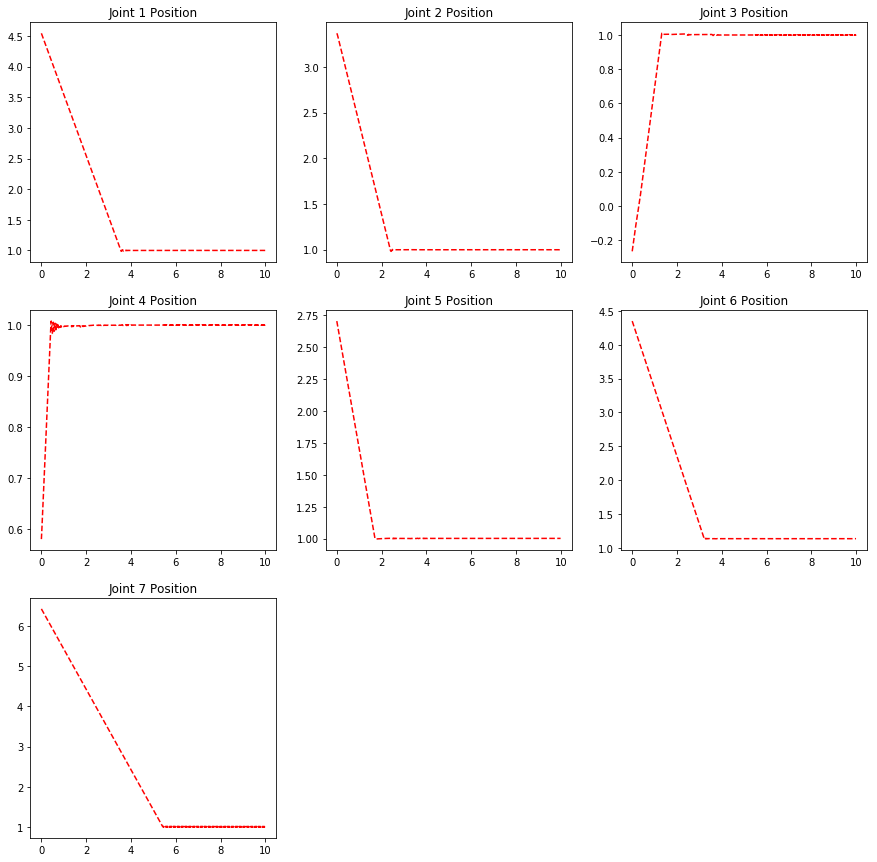

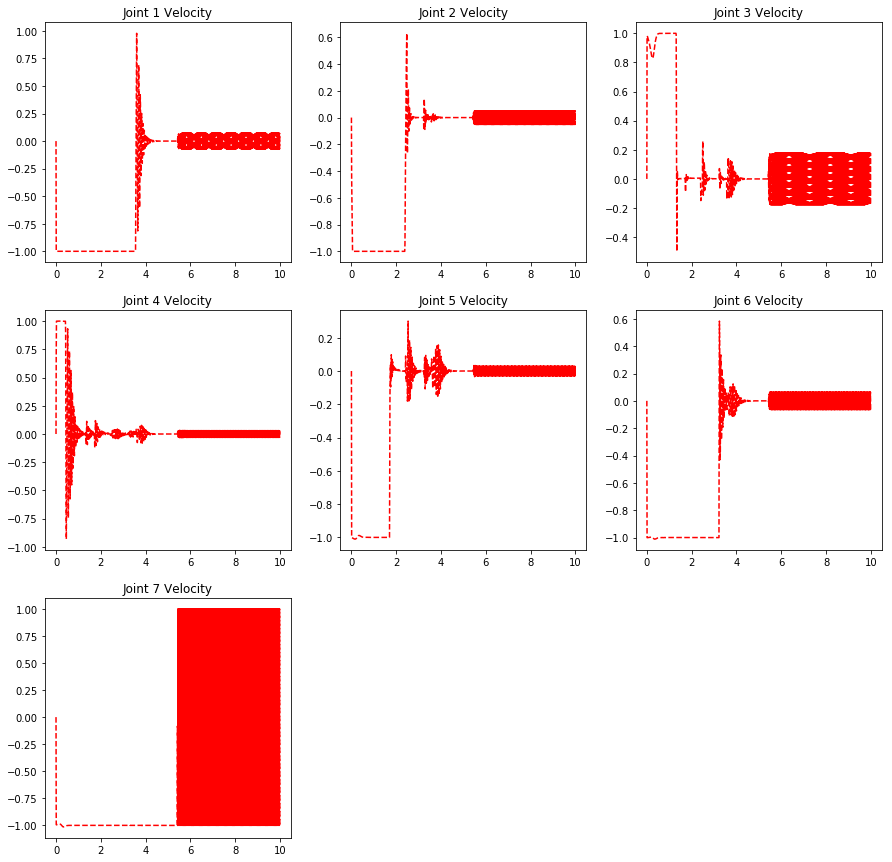

In [4]:
#plt.plot(p_s[:, 0])

plt.figure(figsize=(15,15))
t = np.arange(0, numSimSteps *0.01, 0.01)
for i in range(7):
    plt.subplot(3,3, i+1)
    plt.plot(t, p_s[:,i], 'r--')
    plt.title('Joint {} Position'.format(i+1))
plt.figure(figsize=(15,15))
for i in range(7):
    plt.subplot(3,3, i+1)
    plt.plot(t, p_v[:,i], 'r--')
    plt.title('Joint {} Velocity'.format(i+1))
 
  

In [13]:
import math
class PID(object):
  def __init__(self):
    self._kp = 0.1
    self._ki = 0.0
    self._kd = 0.0

    self._target_theta = 0.0
    self._sampling_time = 0.01

    self._theta0 = 0.0
    self._thetai = 0.0

  def init_status(self):
    self._theta0 = 0.0
    self._thetai = 0.0

  def set_target_theta(self, theta):
    
    self._target_theta = theta

  def get_target_theta(self):
    return self._target_theta

  def get_velocity(self, theta):
    error = self._target_theta - theta
    self._thetai += error * self._sampling_time
    dtheta = (error - self._theta0) / self._sampling_time
    self._theta0 = error

    duty_ratio = (error * self._kp + self._thetai * self._ki + dtheta * self._kd) / self._sampling_time

    if duty_ratio > 30:
      duty_ratio = 30
    elif duty_ratio < -30:
      duty_ratio = -30

    return duty_ratio

def set_target_thetas(  pid,   simStep):
     
    if simStep == 0:
        pid[1].set_target_theta(-100)
    else:
        return pid
    return pid

class PDControllerStable(object):
    def __init__(self, pb):
        self._pb = pb

    def computePD(self, bodyUniqueId, jointIndices, desiredPositions, desiredVelocities,
                  kps, kds, maxForces, timeStep):
        numJoints = len(jointIndices)
        jointStates = self._pb.getJointStates(bodyUniqueId, jointIndices)
        q1 = []
        qdot1 = []
        zeroAccelerations = []
        for i in range (numJoints):
            q1.append(jointStates[i][0])
            qdot1.append(jointStates[i][1])
            zeroAccelerations.append(0)
        q = np.array(q1)
        qdot=np.array(qdot1)
        qdes = np.array(desiredPositions)
        qdotdes = np.array(desiredVelocities)
        qError = qdes - q
        qdotError = qdotdes - qdot
        Kp = np.diagflat(kps)
        Kd = np.diagflat(kds)
        p =  Kp.dot(qError)
        d = Kd.dot(qdotError)
        forces = p + d

        M1 = self._pb.calculateMassMatrix(bodyUniqueId,q1)
        M2 = np.array(M1)
        M = (M2 + Kd * timeStep)
        c1 = self._pb.calculateInverseDynamics(bodyUniqueId, q1, qdot1, zeroAccelerations)
        c = np.array(c1)
        A = M
        b = -c + p + d
        qddot = np.linalg.solve(A, b)
        tau = p + d - Kd.dot(qddot) * timeStep
        maxF = np.array(maxForces)
        forces = np.clip(tau, -maxF , maxF )
        #print("c=",c)
        return forces

In [29]:


KINOVA_HOME_ANGLE = [4.543, 3.370, -0.264, 0.580, 2.705, 4.350, 6.425, 0, 0,0 ]

timeStep = 0.01
#p.connect(p.GUI)
p.resetSimulation()
p.setPhysicsEngineParameter(numSolverIterations=150)
p.setTimeStep(timeStep)


kinova = Kinova(p,  robot_type='j2s7s300',
                urdfRootPath='/home/drl/PycharmProjects/DeployedProjects/pararl/otter/gym/bullet/assets',
                timeStep=timeStep,
                building_env=False,  # use gym env
                useInverseKinematics=False,  # IMPORTANCE! It determines the mode of the motion.
                torque_control_enabled=False,
                is_fixed=True,
                init_configuration =  KINOVA_HOME_ANGLE,
                state_vis = False,
                robot_info_debug = False,
                  )

p.setGravity(0, 0, -9.81)
numSimSteps = 1000


import matplotlib.pyplot as plt

p_s = []
p_v = []
p_t = []

cmds = []
 
pd_col = PDControllerStable(p)

#kinova.Enable_Torque_mode()

for simStep in range(numSimSteps):
    commands  = np.ones(10)*0.01
     
#     _pid= set_target_thetas( _pid, simStep)
    
#     vel_c =[]
#     js = kinova.GetMotorAngles()
#     for i in range(10):
        
#         vel_c.append(_pid[i].get_velocity( math.degrees(js[i]))/57.295779578552 )
        

#     #kinova.ApplyAction(commands)

    
#     commands = pd_col.computePD( kinova.kinovaUid, kinova.motorIndices, 
#                                 np.ones(10)*1.5, np.ones(10)*0.0, 
#                                 np.ones(10)*0.1, np.ones(10)*0.0, 50, 0.01)
    
    if simStep >= 300:
        commands[7:] = np.array([0.5, 0.5, 0.5])
        
    if simStep >= 700:
        commands[7:] = np.array([1.5, 1.5, 1.5])
    
    cmds.append(commands)             
    kinova.ApplyAction_Velocity(commands)
   # kinova.ApplyAction_Torque(commands)

    p_s.append(kinova.GetMotorAngles())
    p_v.append(kinova.GetMotorVelocities())
    p_t.append(kinova.GetTrueMotorTorques())

    p.stepSimulation()
    time.sleep(0.01)


print('Evaluation is completed.')

 

joint id : {'connect_root_and_world': 0, 'j2s7s300_joint_base': 1, 'j2s7s300_joint_1': 2, 'j2s7s300_joint_2': 3, 'j2s7s300_joint_3': 4, 'j2s7s300_joint_4': 5, 'j2s7s300_joint_5': 6, 'j2s7s300_joint_6': 7, 'j2s7s300_joint_7': 8, 'j2s7s300_joint_end_effector': 9, 'j2s7s300_joint_finger_1': 10, 'j2s7s300_joint_finger_tip_1': 11, 'j2s7s300_joint_finger_2': 12, 'j2s7s300_joint_finger_tip_2': 13, 'j2s7s300_joint_finger_3': 14, 'j2s7s300_joint_finger_tip_3': 15}
Evaluation is completed.


In [14]:
p.getNumJoints(kinova.kinovaUid)

16

In [15]:
pd_col = PDControllerStable(p)
pd_col.computePD( kinova.kinovaUid, kinova.motorIndices, np.ones(10)*0.1, np.ones(10)*0., np.ones(10)*1, np.ones(10)*0.1, 50, 0.01)

array([-50.        , -37.05426963,  37.64312443,  50.        ,
       -50.        , -50.        ,  39.59939982, -13.55960185,
       -12.66284769, -10.23154165])

In [23]:
kinova.GetMotorAngles()

array([ 4.64299117,  3.47      , -0.15442684,  0.67974394,  2.80563959,
        4.45015485,  6.52200154,  0.01000247,  0.00999882,  0.00998918])

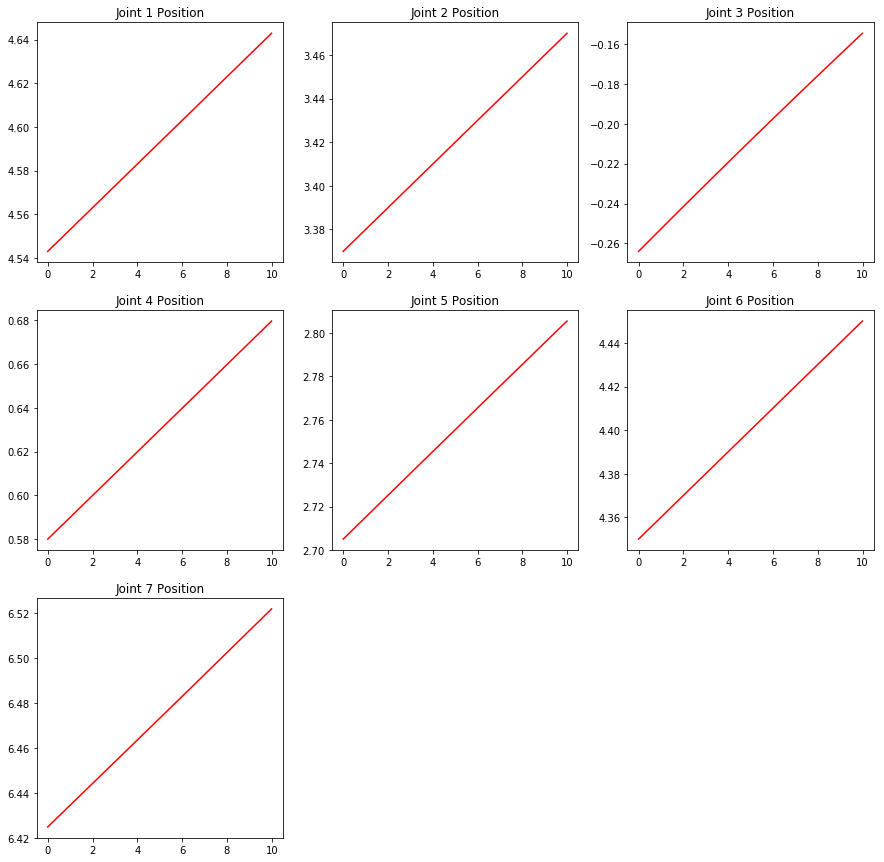

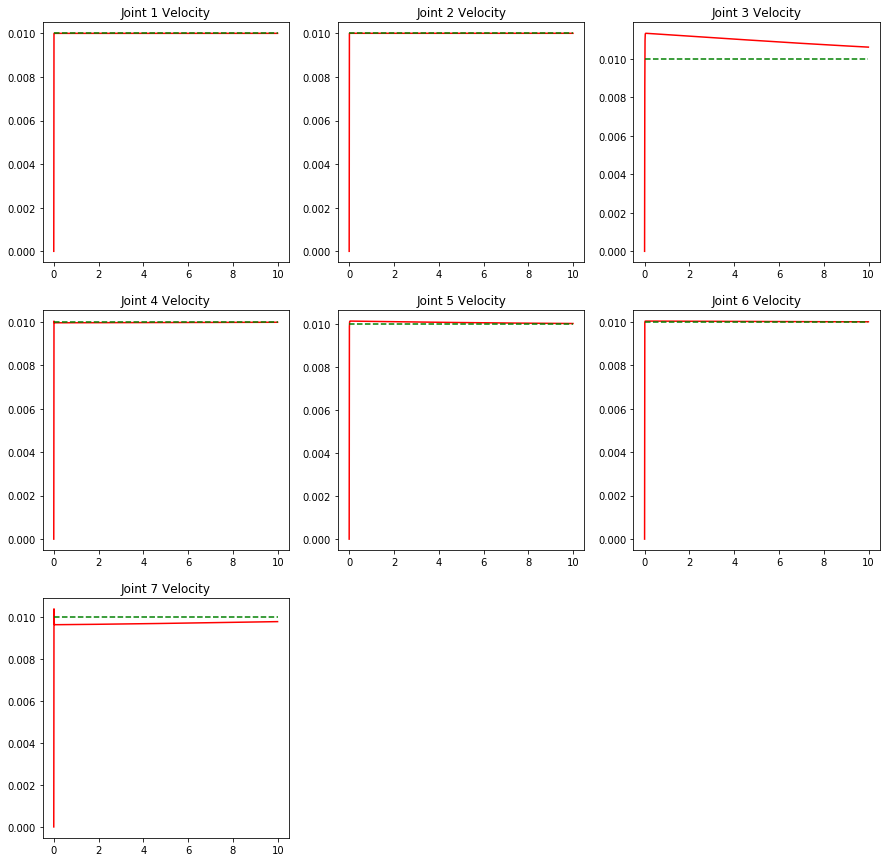

In [25]:
p_s = np.array(p_s)
p_v = np.array(p_v)
p_t = np.array(p_t)
cmds = np.array(cmds)
plt.figure(figsize=(15,15))
t = np.arange(0, numSimSteps *0.01, 0.01)
for i in range(7):
    plt.subplot(3,3, i+1)
    plt.plot(t, p_s[:,i], 'r')
    plt.title('Joint {} Position'.format(i+1))
plt.figure(figsize=(15,15))
for i in range(7):
    plt.subplot(3,3, i+1)
    plt.plot(t, p_v[:,i], 'r')
    plt.plot(t, cmds[:,i], 'g--')
    plt.title('Joint {} Velocity'.format(i+1))

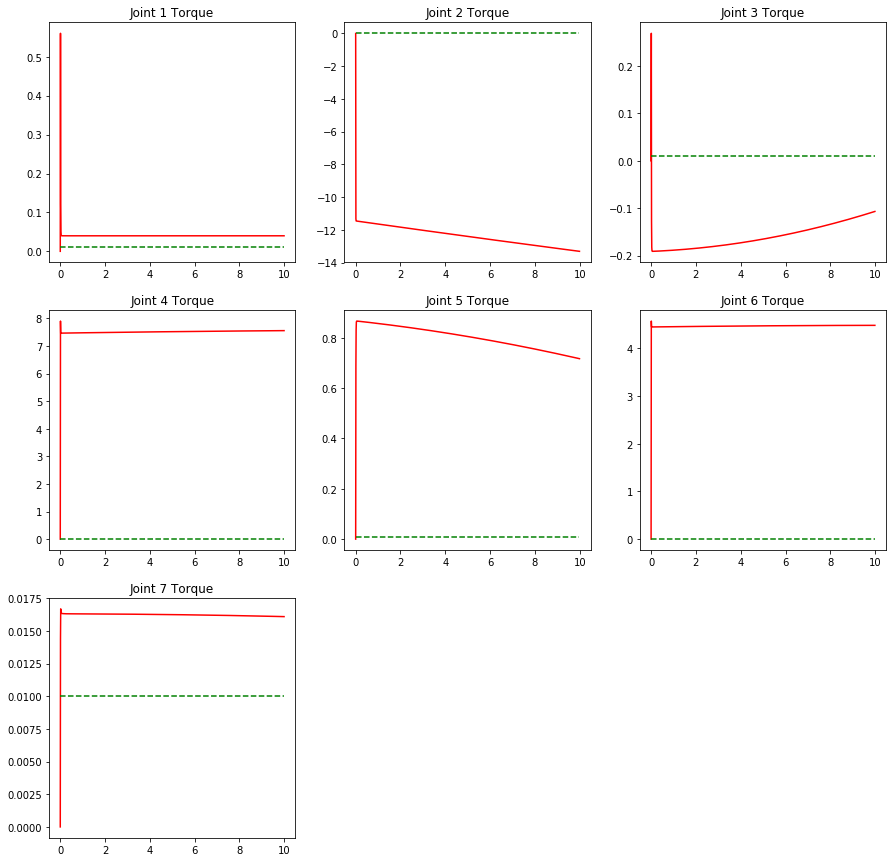

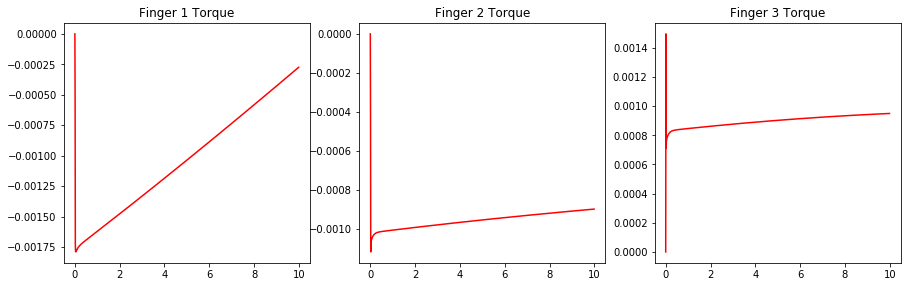

In [27]:
plt.figure(figsize=(15,15))
for i in range(7):
    plt.subplot(3,3, i+1)
    plt.plot(t, p_t[:,i], 'r')
    plt.plot(t, cmds[:,i], 'g--')
    plt.title('Joint {} Torque'.format(i+1))
plt.figure(figsize=(15,15))
for i in range(3):
    plt.subplot(3,3, i+1)
    plt.plot(t, p_t[:,7+i], 'r')
    
    plt.title('Finger {} Torque'.format(i+1))

In [20]:
p_t

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.00664817,
         0.00826804,  0.01076354],
       [ 0.        ,  0.        ,  0.        , ...,  0.01011589,
        -0.0111616 , -0.02293592],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.00278631,
        -0.00633486, -0.00918032],
       [ 0.        ,  0.        ,  0.        , ..., -0.00632161,
        -0.0045661 , -0.00377858],
       [ 0.        ,  0.        ,  0.        , ..., -0.00434989,
        -0.00551315, -0.0067076 ]])